In [14]:
# Temel kütüphaneler
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import cv2

# Grad-CAM için
import tensorflow.keras.backend as K


In [32]:
from google.colab import files
uploaded = files.upload()  # Buradan zip dosyanı seçtim



Saving archive (6).zip to archive (6) (1).zip


In [34]:
!unzip "/content/archive (6).zip" -d /content/intel_data



Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/intel_data/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7652.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7654.jpg  
  inflating: /content/intel_data/seg_train/seg_train/mountain/7662.jpg  
  in

In [35]:
data_dir = "/content/intel_data/seg_train/seg_train"
classes = os.listdir(data_dir)
print("Sınıflar:", classes)


Sınıflar: ['street', 'buildings', 'glacier', 'forest', 'sea', 'mountain']


In [45]:
# Hedef boyut ve batch size
target_size = (100,100)
batch_size = 64

# Eğitim verisi için augmentation (döndürme, zoom, flip vb.)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # %20 validation
)

# Eğitim generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [52]:
def create_model(input_shape=(100,100,3), num_classes=6):
    """
    CNN tabanlı model oluşturur.
    input_shape: Görüntü boyutu (100x100x3)
    num_classes: Sınıf sayısı
    """
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli yeniden oluştur
model = create_model(input_shape=(100,100,3))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372,742 (12.87 MB)

 Trainable params: 3,372,294 (12.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping: validation kaybı 5 epoch boyunca iyileşmezse eğitim duracak
early_stop = EarlyStopping(
    monitor='val_loss',       # validation loss'u takip et
    patience=5,               # 5 epoch boyunca iyileşmezse dur
    restore_best_weights=True # en iyi ağırlıkları geri yükle
)

# Modeli eğit
history = model.fit(
    train_generator,          # eğitim verisi
    validation_data=val_generator, # doğrulama verisi
    epochs=25,                # maksimum 25 epoch
    batch_size=64,            # batch boyutu (GPU verimli kullanımı)
    callbacks=[early_stop],   # EarlyStopping uygula
    verbose=1                 # eğitim sürecini göster
)

# Açıklama:
# - Model, validation loss artarsa 5 epoch sabit kalınca duracak.
# - History objesi, eğitim ve doğrulama accuracy/loss bilgisini tutar.


Epoch 1/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4118 - loss: 2.8876

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.4121 - loss: 2.8813 - val_accuracy: 0.2047 - val_loss: 5.5301
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.5360 - loss: 1.2088 - val_accuracy: 0.2254 - val_loss: 4.1178
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.5898 - loss: 1.1055 - val_accuracy: 0.5382 - val_loss: 1.2302
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.6192 - loss: 1.0185 - val_accuracy: 0.6623 - val_loss: 0.9689
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.6716 - loss: 0.8969 - val_accuracy: 0.6070 - val_loss: 1.0371
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.6909 - loss: 0.8709 - val_accuracy: 0.6462 - val_loss: 1.0050
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7042 - loss: 0.8167 - val_accuracy: 0.7058 - val_loss: 0.8329
Epoch 8/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.7065 - loss: 0.8039 - val_accuracy: 0.540

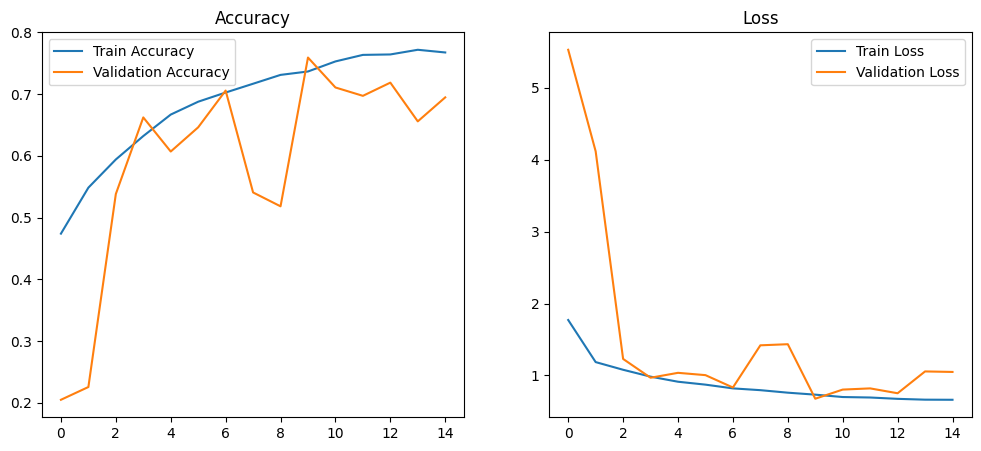

In [54]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()
#Açıklama: Eğitim ve validation accuracy/loss grafikleri ile model performansı görselleştirilir.

44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 541ms/step


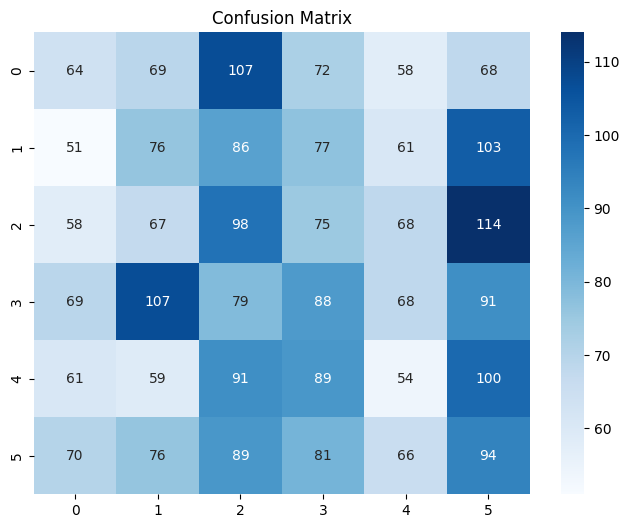

Classification Report
              precision    recall  f1-score   support

   buildings       0.17      0.15      0.16       438
      forest       0.17      0.17      0.17       454
     glacier       0.18      0.20      0.19       480
    mountain       0.18      0.18      0.18       502
         sea       0.14      0.12      0.13       454
      street       0.16      0.20      0.18       476

    accuracy                           0.17      2804
   macro avg       0.17      0.17      0.17      2804
weighted avg       0.17      0.17      0.17      2804



In [55]:
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(val_generator.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("Classification Report")
target_names = list(train_generator.class_indices.keys())
print(classification_report(val_generator.classes, y_pred, target_names=target_names))
#Açıklama:

#Validation set kullanılarak confusion matrix ve sınıflandırma raporu oluşturulur.

In [59]:
def get_gradcam_heatmap(img_array, model, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        # son conv katmanı otomatik bul
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap,0)/tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [58]:
# Modeli kaydet
os.makedirs("/content/saved_models", exist_ok=True)
model.save("/content/saved_models/intel_cnn_model.h5")
print("Model kaydedildi: saved_models/intel_cnn_model.h5")


Model kaydedildi: saved_models/intel_cnn_model.h5
